In [71]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

Formatting The Data

In [73]:
df = pd.read_csv("loan_data.csv")
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [74]:
df['person_education'] = df['person_education'].replace(' ','_',regex=True)
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High_School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High_School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [75]:
df.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [76]:
inputs = df.drop('loan_status',axis=1).copy()
inputs.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No
1,21.0,female,High_School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes
2,25.0,female,High_School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No


In [77]:
output = df['loan_status'].copy()
output.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [78]:
inputs_encoded = pd.get_dummies(inputs, columns=['person_gender',
                                       'person_education',
                                       'person_home_ownership',
                                       'loan_intent',
                                       'previous_loan_defaults_on_file'],dtype=int)
inputs_encoded.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_female,person_gender_male,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,0,...,0,1,0,0,0,0,1,0,1,0
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,1,0,...,1,0,0,1,0,0,0,0,0,1
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,0,...,0,0,0,0,0,1,0,0,1,0
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,0,1,...,0,1,0,0,0,1,0,0,1,0


In [79]:
output.unique()

array([1, 0])

Now Building The Actual ML Model

In [80]:
sum(output)/len(output)

0.2222222222222222

In [81]:
#24.5% of people got loans

In [82]:
df = pd.read_csv("loan_data.csv")
print(df.shape)
print(df['loan_status'].value_counts())


(45000, 14)
loan_status
0    35000
1    10000
Name: count, dtype: int64


In [83]:
inputs_train, inputs_test, output_train, output_test = train_test_split(inputs_encoded, output, random_state = 0, stratify = output)

In [84]:
sum(output_train)/len(output_train)

0.2222222222222222

In [85]:
sum(output_test)/len(output_test)

0.2222222222222222

In [86]:
# Check imbalance
print(f"Default rate: {sum(output)/len(output):.2%}")

Default rate: 22.22%


In [87]:
datatrain = xgb.DMatrix(inputs_train, label=output_train)
datatest = xgb.DMatrix(inputs_test, label=output_test)
scale_pos_weight = (len(output) - sum(output)) / sum(output)
parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'seed': 0,
    'scale_pos_weight': scale_pos_weight  # Balances classes
}
model = xgb.train(parameters,datatrain,num_boost_round=1000,evals=[(datatest, 'eval')],early_stopping_rounds=10,verbose_eval=True)

[0]	eval-aucpr:0.88905
[1]	eval-aucpr:0.90276
[2]	eval-aucpr:0.90822
[3]	eval-aucpr:0.91168
[4]	eval-aucpr:0.91299
[5]	eval-aucpr:0.91581
[6]	eval-aucpr:0.91673
[7]	eval-aucpr:0.91793
[8]	eval-aucpr:0.91943
[9]	eval-aucpr:0.92021
[10]	eval-aucpr:0.92113
[11]	eval-aucpr:0.92224
[12]	eval-aucpr:0.92339
[13]	eval-aucpr:0.92498
[14]	eval-aucpr:0.92551
[15]	eval-aucpr:0.92671
[16]	eval-aucpr:0.92728
[17]	eval-aucpr:0.92757
[18]	eval-aucpr:0.92776
[19]	eval-aucpr:0.92799
[20]	eval-aucpr:0.92882
[21]	eval-aucpr:0.92887
[22]	eval-aucpr:0.93035
[23]	eval-aucpr:0.93060
[24]	eval-aucpr:0.93075
[25]	eval-aucpr:0.93150
[26]	eval-aucpr:0.93173
[27]	eval-aucpr:0.93303
[28]	eval-aucpr:0.93329
[29]	eval-aucpr:0.93329
[30]	eval-aucpr:0.93493
[31]	eval-aucpr:0.93519
[32]	eval-aucpr:0.93581
[33]	eval-aucpr:0.93607
[34]	eval-aucpr:0.93692
[35]	eval-aucpr:0.93726
[36]	eval-aucpr:0.93768
[37]	eval-aucpr:0.93756
[38]	eval-aucpr:0.93776
[39]	eval-aucpr:0.93769
[40]	eval-aucpr:0.93798
[41]	eval-aucpr:0.93783
[4

In [88]:
print("Class Distribution:")
print(f"Total samples: {len(output)}")
print(f"Approved (1): {sum(output)} ({sum(output)/len(output)*100:.1f}%)")
print(f"Denied (0): {len(output) - sum(output)} ({(len(output)-sum(output))/len(output)*100:.1f}%)")

Class Distribution:
Total samples: 45000
Approved (1): 10000 (22.2%)
Denied (0): 35000 (77.8%)


In [89]:
## THIS CODE WORKS FOR BIGGER DATASET
##Analytics and class size too small cuz we working with example dataset rn

#  Cross-validation check
print("\n" + "="*50)
print("CROSS-VALIDATION CHECK")
print("="*50)

# Update your parameters
parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # Changed from 'aucpr' to 'auc'
    'seed': 0
}

# Run CV
dtrain_full = xgb.DMatrix(inputs_encoded, label=output)

cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_full,
    num_boost_round=1000,
    nfold=3,
    stratified=True,
    metrics='auc',  # Changed metric
    early_stopping_rounds=10,
    seed=0,
    verbose_eval=False
)

print(f"\nCV Results:")
print(f"Best iteration: {len(cv_results)}")
print(f"\nCV Mean ROC-AUC: {cv_results['test-auc-mean'].iloc[-1]:.4f} "
      f"(+/- {cv_results['test-auc-std'].iloc[-1]:.4f})")


CROSS-VALIDATION CHECK

CV Results:
Best iteration: 78

CV Mean ROC-AUC: 0.9777 (+/- 0.0005)


In [90]:
output_probability = model.predict(datatest)
output_prediction = np.where(output_probability >= 0.914, 1, 0)
output_prediction

array([1, 0, 1, ..., 1, 0, 1])

Plotting Data To Show Potential Mistakes

Confusion Matrix Interpretation Sheet: 

Top-left: True Negatives - Model Denies and Actual Denies

Top-right: False Positives - Model Approves and Actual Denies

Bottom-left: False Negatives - Model Denies and Actual Approves

Bottom-right: True Positives - Model Approves and Actual Approves

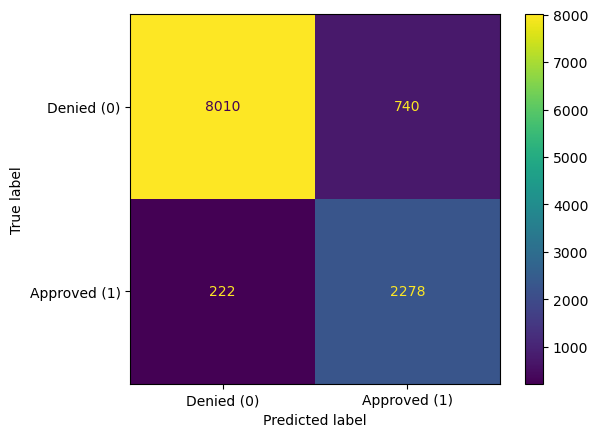

In [91]:
conf_matr = confusion_matrix(output_test, output_prediction)
ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=["Denied (0)", "Approved (1)"]).plot()

In [92]:
# Precision: Shows of all loans model predicted as approved, how many were actually approved
# Recall: Which loans were actually approved and which did the model correctly predict? 
# f1-score: Mean between precision and recall
# Accuracy: Percentage of all loan predictions that the model got correct 

print (classification_report(output_test, output_prediction))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      8750
           1       0.75      0.91      0.83      2500

    accuracy                           0.91     11250
   macro avg       0.86      0.91      0.88     11250
weighted avg       0.92      0.91      0.92     11250

